In [1]:
import videoReplayFast

falling back to slow disk


In [2]:
gen = videoReplayFast.threadedProvide()

In [3]:
gen.gi_frame.f_locals

{}

In [4]:
q = next(gen)

[h264 @ 0x55fb960488c0] mmco: unref short failure
[h264 @ 0x55fb93aef680] mmco: unref short failure
[h264 @ 0x55fb93b37900] mmco: unref short failure
Process Process-5:
Traceback (most recent call last):
  File "/playpen-raid1/tgreer/anaconda3/envs/tensorflow/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/playpen-raid1/tgreer/anaconda3/envs/tensorflow/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/playpen-raid1/tgreer/FeatureMapICON/tensorflow/videoReplayFast.py", line 71, in grabShufflePut
    grabShufflePutStep(inp, out)
  File "/playpen-raid1/tgreer/FeatureMapICON/tensorflow/videoReplayFast.py", line 67, in grabShufflePutStep
    out.put(x[indices[i * 64 : (i + 1) * 64]])
  File "/playpen-raid1/tgreer/anaconda3/envs/tensorflow/lib/python3.8/multiprocessing/queues.py", line 83, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt


In [5]:
import tensorflow as tf
import numpy as np

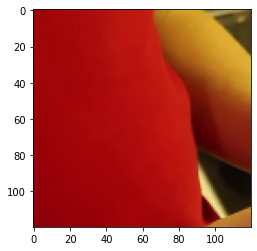

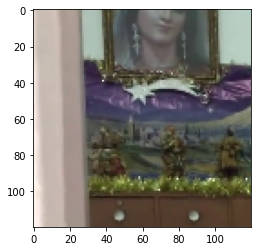

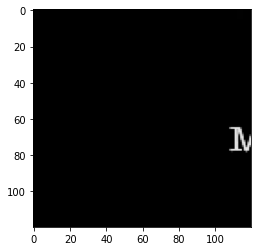

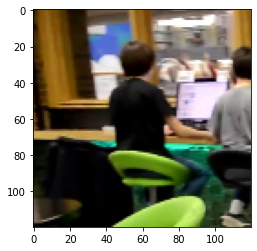

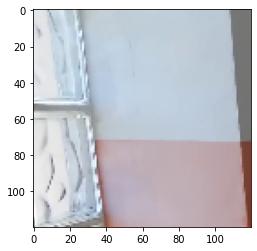

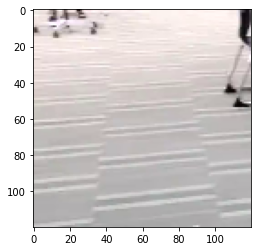

In [6]:
def training_generator():
    while True:
        inp = next(gen).numpy().astype(np.float32) / 255.
        yield (inp[:, :, :, [2, 1, 0]], inp[:, :, :, [6, 5, 4]]), inp[:, :, :, [6, 5, 4]]

import matplotlib.pyplot as plt
for _ in range(6):
    plt.imshow(next(training_generator())[0][0][0])
    plt.show()

In [7]:
import numpy as np

In [8]:
import tensorflow as tf

strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU


In [94]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # Gobal batch size.

LEARNING_RATE = 0.001
LEARNING_RATE_EXP_DECAY = 1

SCALE = 1
SIDE_LENGTH = 90





In [10]:
q = training_generator()


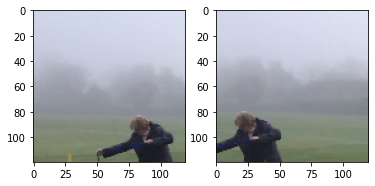

In [23]:
import matplotlib.pyplot as plt
a = next(q)
plt.subplot(1, 2, 1)
plt.imshow(a[0][0][60])
plt.subplot(1, 2, 2)
plt.imshow(a[0][1][60])

In [12]:
FEATURE_LENGTH = 128

def make_model():
    model = tf.keras.Sequential(
      [
        
        #tf.keras.layers.ZeroPadding2D(padding=(15, 15), input_shape=(SIDE_LENGTH, SIDE_LENGTH, 1)),
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=128, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=256, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
       
        tf.keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm
       
        tf.keras.layers.Conv2D(filters=128, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        #tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        #tf.keras.layers.Activation('relu'), # activation after batch norm
      ])
    
    input_A = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    input_B = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    features_A = model(input_A)
    features_B = model(input_B)

    features_A = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, FEATURE_LENGTH))(features_A)
    features_B = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, FEATURE_LENGTH))(features_B)

    cc = tf.keras.layers.Lambda(lambda var: tf.linalg.matmul(var[0], var[1], transpose_b=True), name="matmul")([features_A, features_B])

    cc_A = tf.keras.layers.Softmax(axis=-1)(cc)
    cc_B = tf.keras.layers.Softmax(axis=-2)(cc)

    loss = tf.keras.layers.Multiply()([cc_A, cc_B])
    
    loss = tf.keras.layers.Lambda(lambda var: tf.math.reduce_sum(var, axis=-1))(loss)


    loss = tf.keras.layers.Lambda(lambda var: tf.clip_by_value(var, 0, .6), name="clip")(loss)

    def fmapICON_clamp_loss(tensor, nonsense):
    
      return -tf.math.reduce_sum(nonsense) / BATCH_SIZE / SIDE_LENGTH / SIDE_LENGTH * strategy.num_replicas_in_sync

    outer_model = tf.keras.Model(inputs=(input_A, input_B), outputs=loss)

    outer_model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss=fmapICON_clamp_loss)
    return outer_model
    
with strategy.scope():
    model = make_model()
# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)



2021-09-18 17:56:25.167712: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-18 17:56:29.208278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22357 MB memory:  -> device: 0, name: RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2021-09-18 17:56:29.213723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22357 MB memory:  -> device: 1, name: RTX A5000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2021-09-18 17:56:29.223989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 90, 90, 128)  5178880     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 8100, 128)    0           sequential[0][0]             

In [81]:
model.load_weights("results/clip.6_10/epoch59/model_weights.tf")

In [139]:
(A, B), Q = a
ofs = 10
A = A[ofs:]
B = B[ofs:]


In [140]:
x = model((A[:10], B[:10]))

In [141]:
#plt.figure(figsize=(40, 40))
#plt.imshow(x[2, :2000, :2000])

In [142]:
inner_model = model.layers[2]

In [143]:
F_A = tf.reshape(inner_model(A)[:10], (10, SIDE_LENGTH ** 2, FEATURE_LENGTH))
F_B = tf.reshape(inner_model(B)[:10], (10, SIDE_LENGTH ** 2, FEATURE_LENGTH))
cc = tf.linalg.matmul(F_A, F_B, transpose_b=True)
cc_saved = cc
cc = tf.nn.softmax(cc, axis=-1)
cc = tf.reshape(cc, [10] + [SIDE_LENGTH] * 4)
cc = np.array(cc)

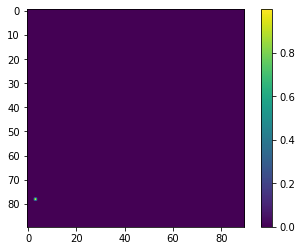

In [144]:
plt.imshow(cc[0, 46, 68])
plt.colorbar()

/playpen-raid1/tgreer/anaconda3/envs/tensorflow/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


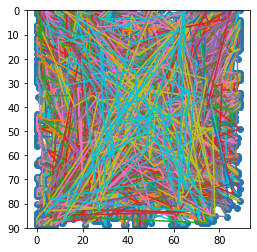

In [145]:
plt.figure(figsize=(4, 4))
import scipy.ndimage
cc[cc < .05] = 0
grid = np.array(
  [
    [
        [
            scipy.ndimage.measurements.center_of_mass(cc[k, i, j].transpose())
            for i in range(SIDE_LENGTH)
        ]
        for j in range(SIDE_LENGTH)
    ]
   for k in range(10)]
)
#grid[:, :, 0] = scipy.ndimage.gaussian_filter(grid[:, :, 0], 1)
#grid[:, :, 1] = scipy.ndimage.gaussian_filter(grid[:, :, 1], 1)

#grid = grid[3:-3, 3:-3]

plt.plot(grid[0, :, :, 0], grid[0, :, :, 1])
plt.plot(grid[0, :, :, 0].transpose(), grid[0, :, :, 1].transpose())
plt.ylim(SIDE_LENGTH, 0)

plt.scatter(grid[0, :, :, 0], grid[0, :, :, 1])

plt.ylim(SIDE_LENGTH, 0)
plt.show()

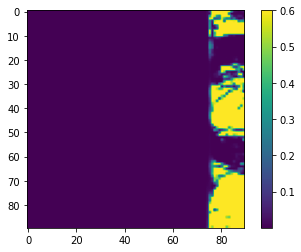

In [146]:
plt.imshow(tf.reshape(x[1], (SIDE_LENGTH, SIDE_LENGTH)))
plt.colorbar()



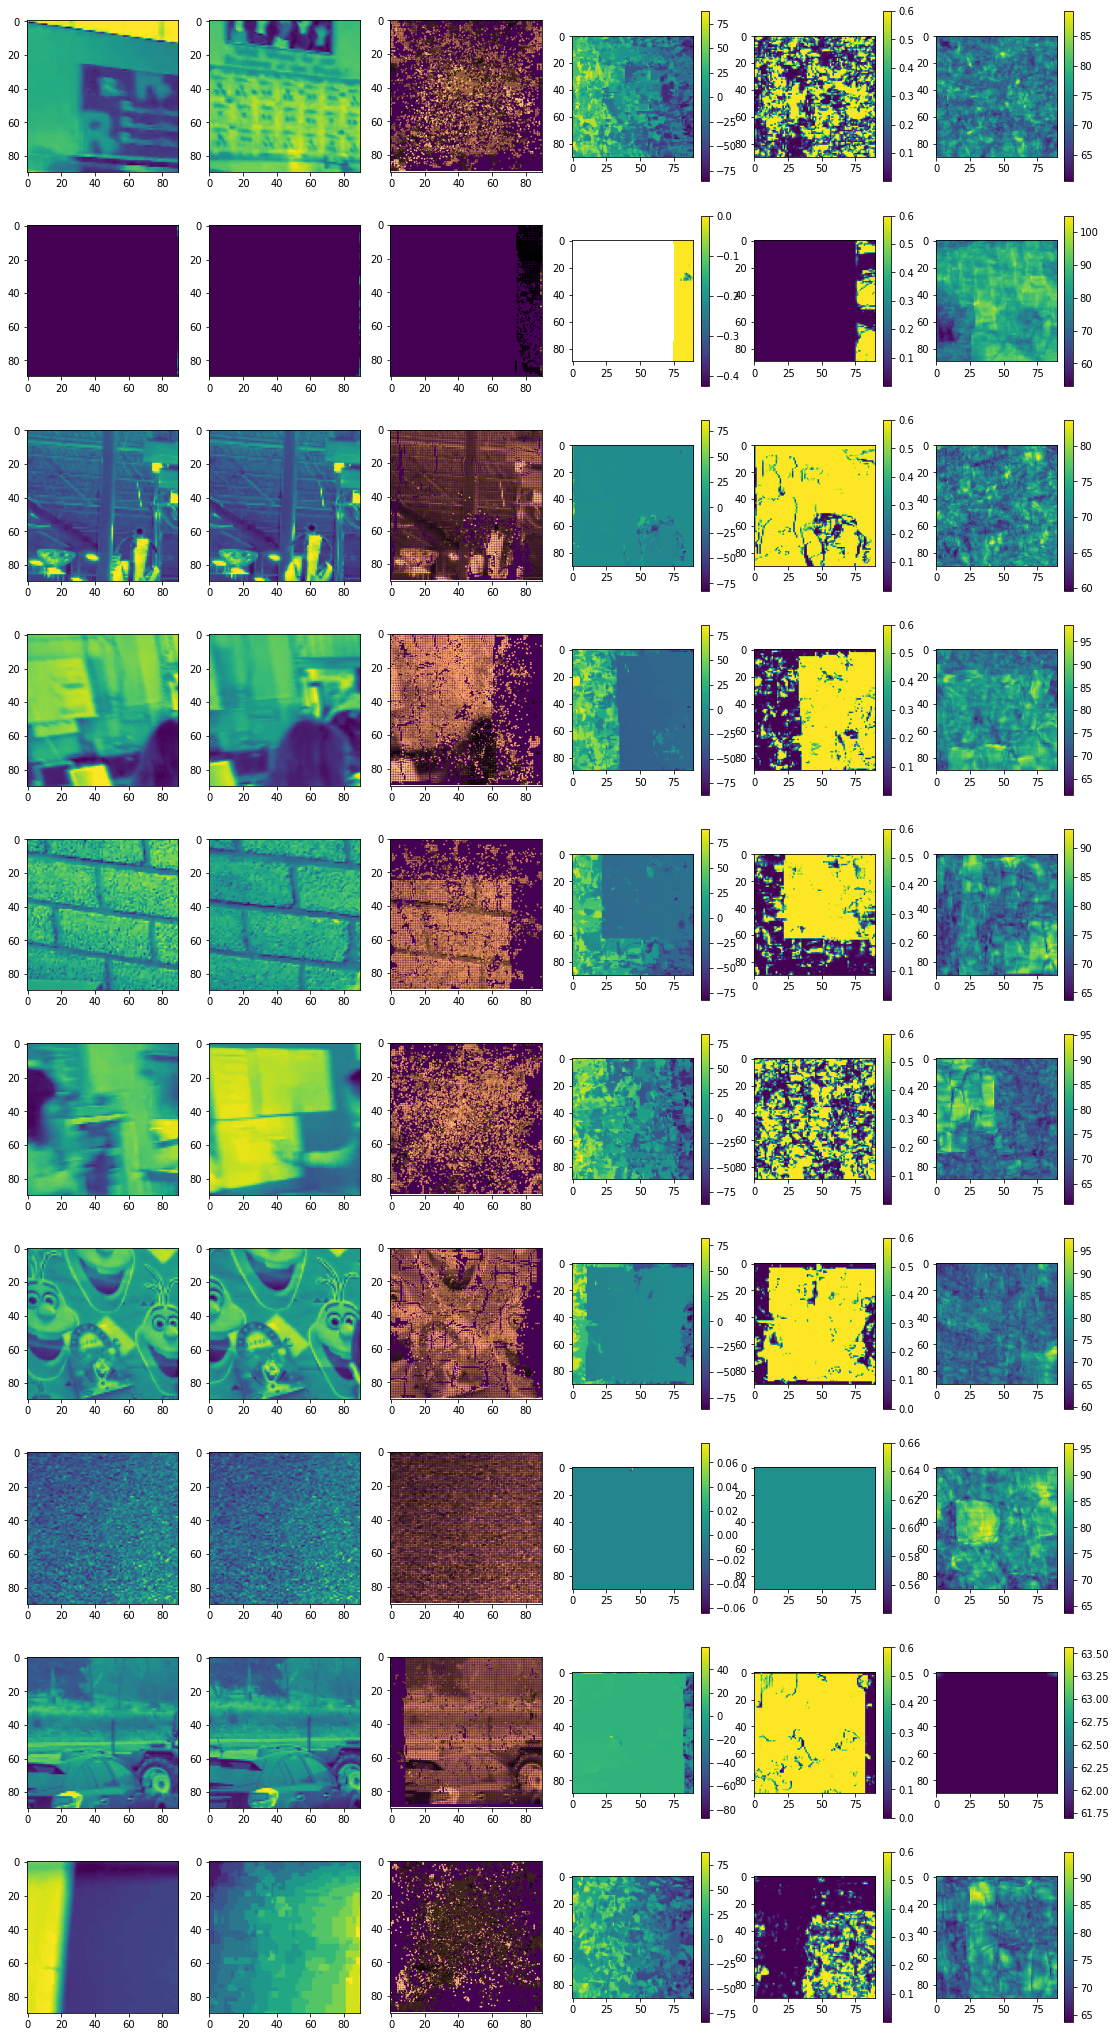

In [147]:
frames_across = 6
plt.figure(figsize=(19, 37))
for k in range(10):
    row_ofs = k * frames_across
    
    plt.subplot(10, frames_across, 1 + row_ofs)
    plt.imshow(A[k, 15:-15, 15:-15, 0])
    plt.subplot(10, frames_across, 2+ row_ofs)
    plt.imshow(B[k, 15:-15, 15:-15, 0])
    plt.subplot(10, frames_across, 3+ row_ofs)
    plt.ylim(SIDE_LENGTH, 0)
    plt.imshow(B[k, 15:-15, 15:-15, 0] * 0)
    plt.scatter(grid[k, :, :, 0], grid[k, :, :, 1], c=np.array(A)[k, 15:-15, 15:-15, 0].transpose(), cmap="copper", s=.5)
    plt.subplot(10, frames_across, 4+ row_ofs)
    g = grid[k].transpose(1, 0, 2)
    plt.imshow(g[:, :, 0] - np.expand_dims(np.arange(90), 0))
    plt.colorbar()
    plt.subplot(10, frames_across, 5+ row_ofs)
    plt.imshow(tf.reshape(x[k], (SIDE_LENGTH, SIDE_LENGTH)))
    plt.colorbar()
    plt.subplot(10, frames_across, 6+ row_ofs)
    plt.imshow(cc_val[k])
    plt.colorbar()

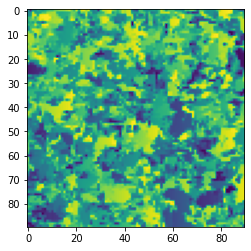

In [105]:
g = grid[0].transpose(1, 0, 2)
plt.imshow(g[:, :, 0])

In [106]:
f_a = np.array(F_A)#.reshape(90, 90, 128)
f_b = np.array(F_B)#.reshape(90, 90, 128)

In [107]:
f_a = f_a.reshape(-1, 128)
f_b = f_b.reshape(-1, 128)

In [108]:

from sklearn import decomposition
pca = decomposition.PCA(n_components=30)

x_a = pca.fit_transform(f_a)
x_b = pca.fit_transform(f_b)

In [109]:
x.shape

TensorShape([10, 8100])

In [110]:
x_a = x_a.reshape(10, 90, 90, 30)
x_b = x_b.reshape(10, 90, 90, 30)

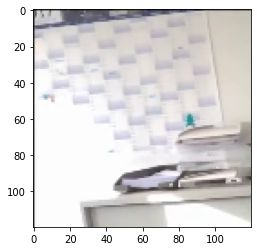

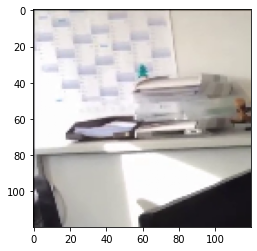

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


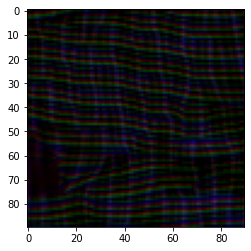

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


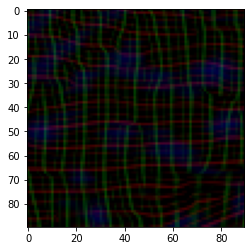

In [111]:
dd = 0
dd += 1
dd %= 10
plt.imshow(A[dd])
plt.show()
plt.imshow(B[dd])
plt.show()
plt.imshow(x_a.reshape(10, 90, 90, 30)[dd, :, :, 6:9] / 16)
plt.show()
plt.imshow(x_b.reshape(10, 90, 90, 30)[dd, :, :, 6:9] / 16)

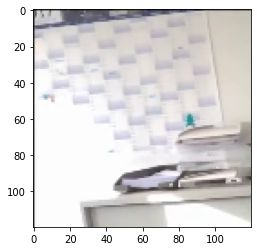

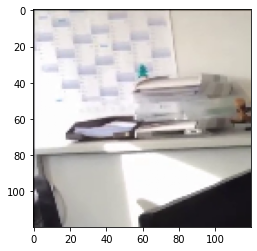

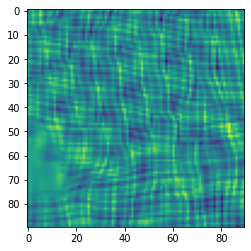

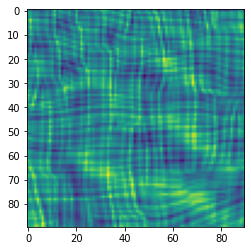

In [115]:
#dd = 0
dd += 1
dd %= 10
plt.imshow(A[dd])
plt.show()
plt.imshow(B[dd])
plt.show()
plt.imshow(np.sum(f_a.reshape(10, 90, 90, 128), axis=-1)[dd])
plt.show()
plt.imshow(np.sum(f_b.reshape(10, 90, 90, 128), axis=-1)[dd])

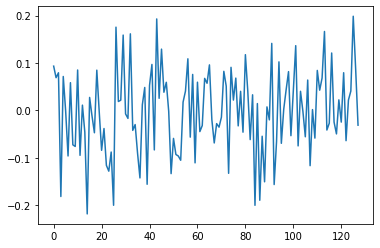

In [113]:
plt.plot(pca.components_[0])

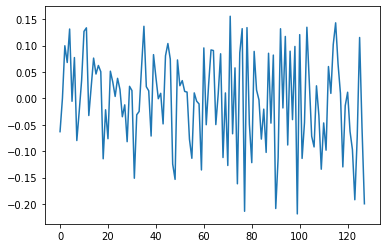

In [60]:
plt.plot(pca.components_[0])

In [116]:
w = model.get_weights()

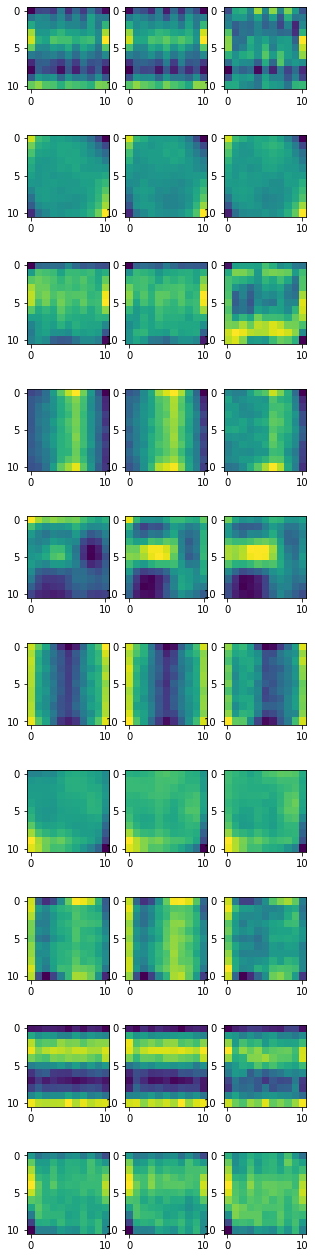

In [117]:
plt.figure(figsize=(5, 23))
for i in range(3):
    for j in range(10):
        plt.subplot(10, 3, 3 * j + i + 1)
        plt.imshow(w[0][:, :, i, j])

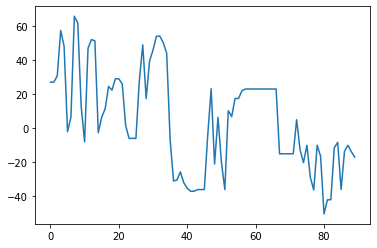

In [118]:
plt.plot(grid[5, 46, :, 1] - range(90))

In [126]:
cc_saved.shape

TensorShape([10, 8100, 8100])

In [129]:
cc_validate = tf.math.reduce_max(cc_saved, axis=-1)

In [133]:
cc_val = tf.reshape(cc_validate, (10, 90, 90))

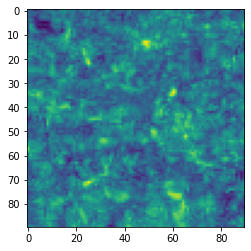

In [134]:
plt.imshow(cc_val[0])

In [65]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#=========================================
# Create Fake Images using Numpy 
# You don't need this in your code as you have your own imageList.
# This is used as an example.


fig = plt.figure(figsize=(10, 10))
ims = []
for i in range(90):
    im = plt.imshow(cc[1, i, i], animated=True, vmin=-20, vmax=100, cmap="jet")
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.close()

# Show the animation
HTML(ani.to_jshtml())

#=========================================
# Save animation as video (if required)
# ani.save('dynamic_images.mp4')


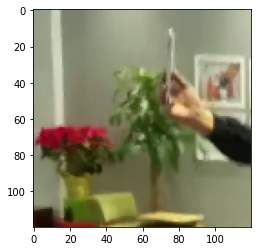

In [154]:
plt.imshow(A[0])

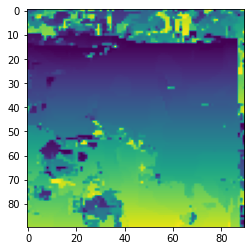

In [153]:
plt.imshow(grid[0, :, :, 0])